# Predicting World Happiness

## Install required packages

In [1]:
!pip install world_bank_data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import world_bank_data as wb
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
import pickle

## Loading required data

In [3]:
data_happiness = pd.read_csv('worldhappiness2019.csv')

In [4]:
data_income = wb.get_countries().reset_index()[['name','incomeLevel']]

In [5]:
data = pd.merge(data_happiness,data_income,on='name',how='left')

In [6]:
X = data.drop(['Happiness_level', 'name', 'Country or region', 'sub-region'], axis=1)
y = data['Happiness_level']

X.shape, y.shape

((156, 8), (156,))

## Clean and preprocessing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0)

print(X_train.shape)
print(y_train.shape)

(117, 8)
(117,)


In [8]:
numeric_features = X.columns.tolist()
numeric_features.remove('region')
numeric_features.remove('incomeLevel')

numeric_transformer = Pipeline(steps=[
                    ('imputer',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())])

categorical_features = ['region','incomeLevel']

categorical_transformer = Pipeline(steps=[
                    ('imputer',SimpleImputer(strategy='most_frequent')),
                    ('onehot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
          transformers=[
                      ('num',numeric_transformer,numeric_features),
                      ('cat',categorical_transformer,categorical_features)
                      ])

preprocess = preprocessor.fit(X_train)

In [43]:
def preprocessor(data):
    preprocessed_data = preprocess.transform(data)
    return preprocessed_data

## Exploratory analysis

In [10]:
X.describe()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,0.905147,1.208814,0.725244,0.392571,0.184846,0.110603
std,0.398389,0.299191,0.242124,0.143289,0.095254,0.094538
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.602750,1.055750,0.547750,0.308000,0.108750,0.047000
50%,0.960000,1.271500,0.789000,0.417000,0.177500,0.085500
75%,1.232500,1.452500,0.881750,0.507250,0.248250,0.141250
max,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000


In [11]:
y.value_counts()

High         32
Very Low     31
Average      31
Low          31
Very High    31
Name: Happiness_level, dtype: int64

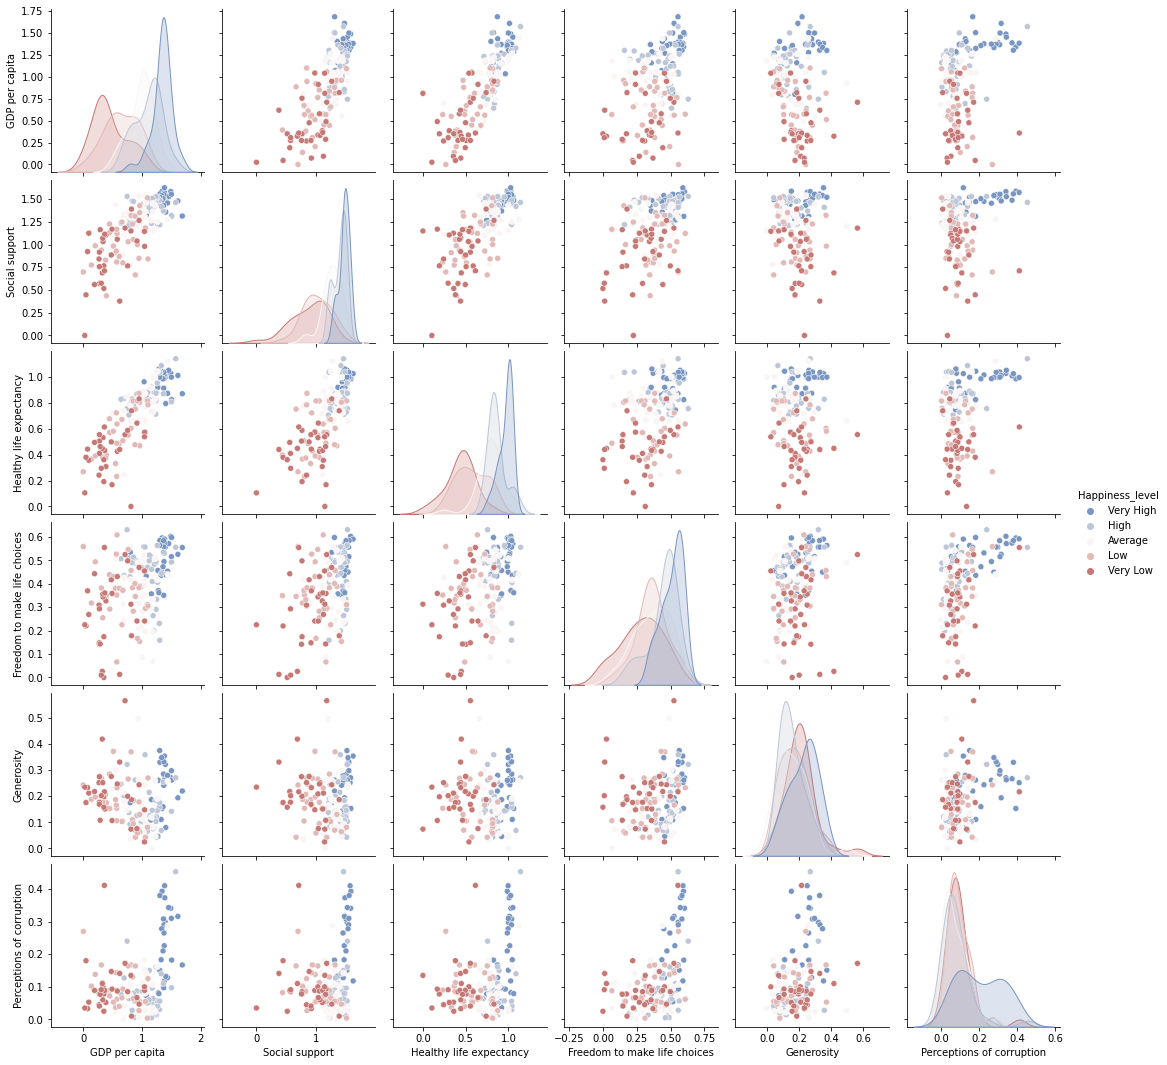

In [12]:
sns.pairplot(pd.concat([X,y],axis=1), hue="Happiness_level", palette='vlag')

**Discussion**: This pairplot is colored by the level of happiness and guided by the individual distribution plots. Visually, the more identifiable are the distributions of happiness level on the individual plots, the higher the relationship is between the variable and the happiness level. So, GDP per capita, Social support, Life expectancy, and Freedom to make choices are those variables. On the other, for example, Very high happy countries are moderately uniformly distributed along all levels of perceptions of corruption, which does not add informationto build a accurate model.

## Model building

### Feature selection

In [13]:
m_dtree = DecisionTreeClassifier()
m_dtree.fit(preprocessor(X_train), y_train)

DecisionTreeClassifier()

In [14]:
m_dtree.feature_importances_

array([0.28754797, 0.1572884 , 0.26200898, 0.05688943, 0.08008674,
       0.06474674, 0.        , 0.05814718, 0.        , 0.        ,
       0.        , 0.01901975, 0.01426481, 0.        , 0.        ])

In [15]:
X.columns

Index(['GDP per capita', 'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'region', 'incomeLevel'],
      dtype='object')

**Discussion**: Based on the decision tree, all of the numeric variables have some influence on the target class, specially GDP per capita, Social support and Healthy life expectancy. Regarding the categorical variables, region_Europe, region_Oceania, High income, and Lower middle income have a relationship with the Happinness Level.

### Model selection and performance

In [16]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC

def model_builder(features_train,target_train,features_test,target_test):
    clf_svc = LinearSVC(random_state=0)
    clf_svc.fit(features_train,target_train)
    clf_bag = BaggingClassifier(random_state=0)
    clf_bag.fit(features_train,target_train)
    clf_forest = RandomForestClassifier(random_state=0)
    clf_forest.fit(features_train,target_train)

    score_clf_svc = clf_svc.score(features_test,target_test)
    score_clf_bag = clf_bag.score(features_test,target_test)
    score_clf_forest = clf_forest.score(features_test,target_test)
    return score_clf_svc, score_clf_bag, score_clf_forest

In [17]:
print('Scores for SVC, Bagging, and Random Forest:')
model_builder(preprocessor(X_train)[:,:4],y_train,preprocessor(X_test)[:,:4],y_test)

Scores for SVC, Bagging, and Random Forest:


(0.5641025641025641, 0.5128205128205128, 0.5384615384615384)

**Discussion**: Based on the accuracy scores tried on the Linear SVC, Bagging Classifier, and Random Forest, Linear SVC is the model with the highest score on the test dataset. All of these models were tested with the default parameters, so now, the parameters should be optimized to find the ones that produce the highest score using a grid search. The model is using only the four first features that the pairplot and Decision Tree showed as the most important for the prediction.

### Model selection

#### Linear SVC

In [18]:
import warnings
warnings.filterwarnings("ignore")

parameters = {'C':np.linspace(0,100,1000),'penalty':('l1','l2')}
svc = LinearSVC(random_state=0)
clf = GridSearchCV(svc, parameters)
clf.fit(preprocessor(X_train)[:,:4],y_train)

GridSearchCV(estimator=LinearSVC(random_state=0),
             param_grid={'C': array([  0.        ,   0.1001001 ,   0.2002002 ,   0.3003003 ,
         0.4004004 ,   0.5005005 ,   0.6006006 ,   0.7007007 ,
         0.8008008 ,   0.9009009 ,   1.001001  ,   1.1011011 ,
         1.2012012 ,   1.3013013 ,   1.4014014 ,   1.5015015 ,
         1.6016016 ,   1.7017017 ,   1.8018018 ,   1.9019019 ,
         2.002002  ,   2.1021021 ,   2.2022022 ,   2.3023023 ,
         2.4024024 ,   2.5025025 ,   2.6026026 ,   2.7027027 ,
         2.80280...
        96.8968969 ,  96.996997  ,  97.0970971 ,  97.1971972 ,
        97.2972973 ,  97.3973974 ,  97.4974975 ,  97.5975976 ,
        97.6976977 ,  97.7977978 ,  97.8978979 ,  97.997998  ,
        98.0980981 ,  98.1981982 ,  98.2982983 ,  98.3983984 ,
        98.4984985 ,  98.5985986 ,  98.6986987 ,  98.7987988 ,
        98.8988989 ,  98.998999  ,  99.0990991 ,  99.1991992 ,
        99.2992993 ,  99.3993994 ,  99.4994995 ,  99.5995996 ,
        99.6996997

In [19]:
print('Best parameters:', clf.best_params_)
print('Score from cross-validation: {:.5f}'.format(clf.best_score_))

Best parameters: {'C': 87.58758758758759, 'penalty': 'l2'}
Score from cross-validation: 0.53043


In [20]:
clf_svc = LinearSVC(C=clf.best_params_['C'],random_state=0)
clf_svc.fit(preprocessor(X_train)[:,:4],y_train)
print('Training score:',clf_svc.score(preprocessor(X_train)[:,:4],y_train))
print('Test score:',clf_svc.score(preprocessor(X_test)[:,:4],y_test))

Training score: 0.5811965811965812
Test score: 0.5897435897435898


**Discussion**: The grid search cross validated shows that the best parameter of regularization is 87.59 with a penalty of l2 (which is the default). This model has a score of 0.58 on the train dataset and 0.59 on the test dataset. The higher regularization parameter than the default suggests that the optimization is reducing the overfitting that will produce a naive model without penalization of features.

#### Random Forest

In [21]:
parameters = {'n_estimators':(range(1,100,1))}
forest = RandomForestClassifier(random_state=0,max_features=15,criterion='entropy')
clf = GridSearchCV(forest, parameters)
clf.fit(preprocessor(X_train),y_train)

GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              max_features=15, random_state=0),
             param_grid={'n_estimators': range(1, 100)})

In [22]:
print('Best parameters:', clf.best_params_)
print('Score from cross-validation: {:.6f}'.format(clf.best_score_))

Best parameters: {'n_estimators': 10}
Score from cross-validation: 0.573551


In [23]:
clf_for = RandomForestClassifier(n_estimators=clf.best_params_['n_estimators'],criterion='entropy',random_state=0)
clf_for.fit(preprocessor(X_train),y_train)
print('Training score:',clf_for.score(preprocessor(X_train),y_train))
print('Test score:',clf_for.score(preprocessor(X_test),y_test))

Training score: 0.9829059829059829
Test score: 0.4358974358974359


**Discussion**: The grid search cross validated shows that the best parameters are 10 trees in the random forest and entropy as the best criterion, different from the default (100 trees and gini as the criterion). This model has a score of 0.98 on the train dataset and 0.44 on the test dataset. The lower score compared to the Linear SVC suggests that, given the relatively small dataset, a non-ensemble model, like the Linear SVC can provide better results. So Liner SVC is the choosen model for this problem. Here, the model is training with all the features since the Random Forest can automatically select the features.

### Prepare to publish

Predict the labels using the LinearSVC and change the preprocessor for submission.

In [55]:
predicted_labels=clf_svc.predict(preprocessor(X_test)[:,:4])

In [56]:
def preprocessor(data):
    preprocessed_data = preprocess.transform(data)
    preprocessed_data = preprocessed_data[:,:4]
    return preprocessed_data

## Publising best model to AI Model Share

In [ ]:
! pip install aimodelshare --extra-index-url https://test.pypi.org/simple/ 

In [57]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

In [58]:
#test your preprocessor
prep=ai.import_preprocessor("preprocessor.zip")
prep(X_test)

array([[-0.27960293,  0.21644376,  0.06491145,  1.04553941],
       [ 0.78225684,  1.07583777,  0.57681972,  0.77664209],
       [ 0.80412581,  0.9962028 ,  0.60481471, -0.3056696 ],
       [-0.08764201,  0.36244119, -1.01089579,  0.14473341],
       [ 1.10057178,  0.75066166,  0.73679106, -0.19138824],
       [ 0.94262925,  1.17206336,  1.1847108 ,  1.38166105],
       [-0.08035235,  0.09367318,  0.11290285,  0.7363075 ],
       [ 0.10917868,  0.74070729,  0.30086917, -1.51570751],
       [-0.81903741, -0.48368033, -1.21485924,  0.34640639],
       [-0.4132466 ,  1.07915589,  0.10490428,  1.69089297],
       [ 0.17478558,  0.06712819,  0.340862  , -1.09891668],
       [ 0.32786834,  0.68098106,  0.39285268,  1.19343293],
       [-0.82875695, -0.27132042, -0.37101044,  1.54299944],
       [-1.47510637, -0.87853704, -1.20686068,  0.01700718],
       [ 0.49796029,  0.6577542 ,  0.27287418,  0.79680939],
       [ 0.30599937, -0.19500357, -0.7669395 ,  0.50774478],
       [ 1.59626833,  0.

### Save model to onnx

In [47]:
# Save sklearn model to onnx file
import aimodelshare as ai
from aimodelshare.aimsonnx import model_to_onnx

# How many preprocessed input features are there?
# Change numeric value in FloatTensorType to update
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, 15]))]

# transform sklearn model to ONNX
onnx_model_sklearn = model_to_onnx(clf_for, framework='sklearn', 
                                   initial_types=initial_type,                  # think about automating initial types
                                   transfer_learning=False,
                                   deep_learning=False,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_sklearn.onnx", "wb") as f:
    f.write(onnx_model_sklearn.SerializeToString())